In [1]:
# Text files
alice_txt = '../data/alice.txt'
songs_txt = '../data/songs.txt'

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


tf.logging.set_verbosity(tf.logging.WARN)
pd.set_option('display.max_colwidth', -1)

Text Generation Using RNNs
==========================
#### Authors: Alexandria Davis, Donald Dong
- [Github](https://github.com/donaldong/rnn-text-gen)

# Introduction
Text generation is a popular problem in Data Science and Machine Learning, and
it is a suitable task for Recurrent Neural Nets.  This report uses tensorflow
to build an RNN text generator and builds a high-level API in Python3. The
report is inspired by @karpathy (
[min-char-rnn](https://gist.github.com/karpathy/d4dee566867f8291f086)) and
Aurélien Géron (
[Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291)
). This is a class project in CST463 - Advanced Machine Learning at Cal State
Monterey Bay, instructed by Dr. Glenn Bruns.

# Modules
`Dataset`, `RNNTextGenerator`, and `ModelSelector` are the three main modules.

## Dataset
Defined in
[src/dataset.py](https://github.com/donaldong/rnn-text-gen/blob/master/src/dataset.py)

Creates a text dataset contains the one-hot encoded text data. It produces
batches of sequences of encoded labels. We split the text data into batches are
used to train the RNN, and we sample a random chuck of the text (with given
length) to evaluate the performance of our data.

### Attributes

#### seq_length
The number of consecutive characters in a slice of the text data (for batching).

#### vocab_size
The number of unique characters in the text data.

### Methods

#### constructor
```
Dataset(
  filenames,
  seq_length,
  shuffle=True
)
```
##### Args
- `filenames`
A list of filenames. They are the paths to one or more plain text files. The
file contents are concatenated in the given order.
- `seq_length`
The number of encoded labels in a sequence. It's the one-hot encoded output of
a slice of consecutive characters in the text.
- `shuffle`
Whether to shuffle the sequences. Default to `True`. When it is set to `False`,
it will batch the sequences in order of the original text.

#### encode
```
encode(text)
```
One-hot encode the text.

##### Args
- `text`
The original character sequence.

##### Returns
The one-hot encoded character sequence.

##### Example
```python
dataset = Dataset([filename], seq_length)
encoded = dataset.encode(text)
assert len(encoded) == len(text)
for label in encoded:
    assert sum(label) == 1
    assert len(label) == dataset.vocab_size
```

#### decode
Decode the one-hot encoded sequence to text format.
```
decode(seq)
```
##### Args
- `seq`
The one-hot encoded character sequence.

##### Returns
The original character sequence.

##### Example
```python
dataset = Dataset([filename], seq_length)
assert dataset.decode(dataset.encode(text)) == text
```

#### batch
```
batch(
    batch_size,
    drop_remainder=True
)
```
Produce many `batch`es. A `batch` has many input and target sequences (`inputs`
and `targets`). Each input and target sequence is a list of encoded labels,
and they offset by 1 timestep, thus they have the same length. With a
sequence `[l0, l0, l1, l1, l2]`, the input sequence would be `[l0, l0,
l1, l1]`, and the target sequence would be `[l0, l1, l1, l2]`.
##### Args
- `batch_size`
The number of instances (sequences) in a single batch.
- `drop_remainder`
Whether the last batch should be dropped in the case of having fewer than
`batch_size` elements.

##### Returns
A number of batches which covers the text data.

##### Example
```python
dataset = Dataset([filename], seq_length)
for batch in dataset.batch(batch_size):
    # The number of elements in the batch is `batch_size`
    assert len(batch.inputs) == batch_size
    assert len(batch.targets) == batch_size
    for i in range(batch_size):
        # Each element in the batch is a sequence
        assert len(batch.inputs[i]) == seq_length
        assert len(batch.targets[i]) == seq_length
        for j in range(seq_length):
            # One-hot encoded
            assert sum(batch.inputs[i][j]) == 1
            assert len(batch.inputs[i][j]) == dataset.vocab_size
```

#### sample
```
sample(batch_size)
```
Radomly select some sequences (with replacement).

##### Args
- `batch_size`
The number of instances (sequences) in a single batch.

##### Returns
A single batch.

##### Example
```python
dataset = Dataset([filename], seq_length)
count = 0
batch = dataset.sample(batch_size)
for seq in batch.inputs:
    assert len(seq) == seq_length
    for i in range(seq_length):
        # One-hot encoded
        assert sum(seq[i]) == 1
        assert len(seq[i]) == dataset.vocab_size
    count += 1
assert count == batch_size
```

In [2]:
class Batch:
    def __init__(self, seqs):
        self._inputs = [seq[:-1] for seq in seqs]
        self._targets = [seq[1:] for seq in seqs]

    @property
    def inputs(self):
        return self._inputs

    @property
    def targets(self):
        return self._targets

In [3]:
class Dataset:
    def __init__(
            self,
            filenames,
            seq_length,
            shuffle=True,
    ):
        text = ''
        vocab = set()
        for filename in filenames:
            with open(filename) as file:
                content = file.read()
                text += content
                vocab = vocab.union(set(content))
        self._seq_length = seq_length
        self._vocab_size = len(vocab)
        self._char_to_ix = {c: i for i, c in enumerate(vocab)}
        self._ix_to_char = list(vocab)
        self._text = text
        self._data = np.array([self._char_to_ix[c] for c in text])
        self._shuffle = shuffle

    def batch(
            self,
            batch_size,
            drop_remainder=True
    ):
        n_seq = len(self._data) // self._seq_length
        n_batch = n_seq // batch_size
        seq_ids = np.arange(n_seq)
        if self._shuffle:
            np.random.shuffle(seq_ids)
        i = 0
        for _ in range(n_batch):
            seqs = [None] * batch_size
            for j in range(batch_size):
                k = seq_ids[i] * self._seq_length
                seqs[j] = self._create_seq(k)
                i += 1
            yield Batch(seqs)
        if not drop_remainder:
            seqs = []
            for j in range(n_seq % batch_size):
                k = seq_ids[i] * self._seq_length
                seqs[j] = self._create_seq(k)
                i += 1
            yield Batch(seqs)

    def sample(self, batch_size):
        n = len(self._text) - self._seq_length
        return Batch([
            self._create_seq(np.random.randint(n))
            for _ in range(batch_size)
        ])

    def encode(self, text):
        return [self._to_label(self._char_to_ix[c]) for c in text]

    def decode(self, seq):
        text = ''
        for label in seq:
            text += self._ix_to_char[np.argmax(label)]
        return text

    @property
    def seq_length(self):
        return self._seq_length

    @property
    def vocab_size(self):
        return self._vocab_size

    def _create_seq(self, i):
        j = i + self._seq_length + 1
        return list(map(self._to_label, self._data[i:j]))

    def _to_label(self, index):
        label = np.zeros(self._vocab_size)
        label[index] = 1.0
        return label

The `Batch` and `Dataset` classes match with karpathy:
- https://gist.github.com/karpathy/d4dee566867f8291f086#file-min-char-rnn-py-L7-L13
- https://gist.github.com/karpathy/d4dee566867f8291f086#file-min-char-rnn-py-L90-L91

## RNNTextGenerator
Defined in
[src/text_generator.py](https://github.com/donaldong/rnn-text-gen/blob/master/src/text_generator.py)

Creates a recurrent neural network with a tensorflow RNNCell cell (which
performs dynamic unrolling of the `inputs`). It has an output projection
layer which produces the final probability for each character class. It
generates the text by sampling the next character based on the probability
distribution of the last character of the current sequence.

### Attributes

#### params
The parameters which define the text generator.

### Methods

#### constructor
```
RNNTextGenerator(
  seq_length,
  vocab_size,
  rnn_cell=tf.nn.rnn_cell.BasicRNNCell,
  n_neurons=100,
  activation=tf.tanh,
  optimizer=tf.train.AdamOptimizer,
  learning_rate=0.001,
  epoch=5,
  batch_size=25,
  name='RNNTextGenerator',
  logdir=None
)
```
Initialize the text generator and contruct the TensorFlow graph.

##### Args
- `seq_length`
The number of encoded labels in a sequence.
- `vocab_size`
The number of unique characters in the text data.
- `rnn_cell`
An RNN cell from `tf.nn.rnn_cell`. The cell has `n_neurons` neurons, takes the
`activation` funtions, and goes into `tf.nn.dynamic_rnn`.
- `n_neurons`
The number of neurons in the RNN cell.
- `activation`
The activation function (callable) for the RNN cell.
- `optimizer`
A subclass of `tf.train.Optimizer`. The optimizer to use for minizing the loss.
- `learning_rate`
A Tensor or a floating point value. The learning rate of the `optimizer`.
- `epoch`
The number of times to iterate through the dataset.
- `batch_size`
The number of instances (sequences) in a single batch.
- `name`
The name of the text generator. It is used for graph visualization in
tensorboard (variable scope), and saving/restoring the model (checkpoint name).
- `logdir`
The path to the tensorflow summary

##### TensorBoard screenshot
![tf_graph](tf_graph.png)

#### fit
```
fit(dataset, save_scores=False)
```
Feed the dataset `epoch` times, with batches of `batch_size` sequences.

##### Args
- `dataset`
A `Dataset` object which creates batches to train the model.
- `save_scores`
Whether to store the training accuracy and loss.

##### Returns
If `save_scores` is `True`, it returns a `pd.DataFrame` which stores the
training accuracy and loss.

##### Example
```python
dataset = Dataset([filename], seq_length)
model = RNNTextGenerator(
    seq_length,
    dataset.vocab_size,
    learning_rate=learning_rate,
    epoch=epoch,
    batch_size=batch_size,
)
scores = model.fit(dataset, save_scores=True)
```

#### score
```
score(dataset, batch_size=None, n_samples=5)
```
Measure the score of the text generator. The score is the average result of
`n_samples` times sampling from the dataset. It tests how the model will
perform on sequences it has not *completely* seen yet.

##### Args
- `dataset`
A `Dataset` object to sample from. A sample is a single `Batch`.
- `batch_size`
The number of instances (sequences) in a single batch. When `batch_size` is
`None`, it uses the `batch_size` for training the model.
- `n_samples`
The number of times to sample from the dataset for testing.

##### Returns
The average accuracy and loss of the `n_samples` samples.

#### predict
```
predict(inputs)
```
Predict the probabilities of the next labels in each input sequence.

##### Args
- `inputs`
The input sequences (with one-hot encoded labels).

##### Returns
The target sequences (with the probabilities of each label). The shape of the
target sequences would be `[len(inputs), seq_length, vocab_size]`.


#### save
```
save(path='./model')
```
Save the model in the specified path. The files use the `name` of the text
generator.

##### Args
- `path`
The path to store the model.

#### restore
```
restore(path='./model')
```
Restore the model in the specified path. It assumes the files use the `name` of
the text generator exists, or it throws exceptions.

##### Args
- `path`
The path where the model is stored.

#### sample
```
sample(self, dataset, start_seq, length)
```
Sample from the text generator based on the predicted probability distribution
for the next label. For example, assume the target for the input sequence
`[l1, l1, l2]` is `[[l1: 90%, l2: 10%], [l1: 10%, l2: 90%], [l1: 10%, l2: 90%]]`,
the next character is sampled from `[l1: 10%, l2: 90%]`. Thus the next
character would be `l2 ` with a probability of `0.9`, or `l1` with a
probability of `0.1`.

##### Args
- `dataset`
A `Dataset` object to encode and decode the labels. This method is sampling
from the text generator, not from the dataset.
- `start_seq`
The character sequence to begin with.
- `length`
The length of the generated text.

##### Returns
The sampled text with `length` characters.

#### generate
```
generate(dataset, start_seq, length)
```
Generate the text from the text generator using the given `start_seq`. This
method wraps the `sample`. It creates a new model with the new sequence length
and restores the previous weights.

##### Args
- `dataset`
A `Dataset` object to encode and decode the labels. This method is sampling
from the text generator, not from the dataset.
- `start_seq`
The character sequence to begin with.
- `length`
The length of the generated text.

##### Returns
The generated text with `length` characters.

##### Example
```python
model.fit(dataset)
print(start_seq + model.generate(
    dataset,
    start_seq,
    50
))
```

In [4]:
class RNNTextGenerator:
    def __init__(
            self,
            seq_length,
            vocab_size,
            rnn_cell=tf.nn.rnn_cell.BasicRNNCell,
            n_neurons=100,
            activation=tf.tanh,
            optimizer=tf.train.AdamOptimizer,
            learning_rate=0.001,
            epoch=5,
            batch_size=25,
            name='RNNTextGenerator',
            logdir=None,
    ):
        self._batch_size = batch_size
        self._epoch = epoch
        self._name = name
        self._tf_graph = tf.Graph()
        with self._tf_graph.as_default():
            self._tf_sess = tf.Session()
            # One-hot encoded input and targets
            """placeholder
            Example
            [
                batch_0: [
                    seq_0: [
                        # encoded labels with 5 categories
                        [0, 0, 0, 1, 0],  # i = 0
                        [0, 0, 1, 0, 0],  # i = 1
                    ],
                    ...
                ],
                ...
            ]
            """
            self._tf_input = tf.placeholder(
                tf.float32,
                shape=(None, seq_length, vocab_size),
                name='inputs',
            )
            self._tf_target = tf.placeholder(
                tf.float32,
                shape=(None, seq_length, vocab_size),
                name='targets'
            )
            with tf.variable_scope(name):
                self._tf_rnn_cell = rnn_cell(
                    n_neurons,
                    activation=activation,
                )
                outputs, _ = tf.nn.dynamic_rnn(
                    self._tf_rnn_cell,
                    tf.cast(self._tf_input, tf.float32),
                    dtype=tf.float32,
                )
                logits = tf.layers.dense(
                    outputs,
                    vocab_size,
                    name='output_projection',
                )
                self._tf_prob = tf.nn.softmax(
                    logits,
                    name='probability',
                )
                with tf.variable_scope('loss'):
                    self._tf_loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits_v2(
                            logits=logits,
                            labels=self._tf_target,
                        )
                    )
                self._tf_train = optimizer(
                    learning_rate=learning_rate
                ).minimize(self._tf_loss)
                with tf.variable_scope('accuracy'):
                    self._tf_acc = tf.reduce_mean(tf.cast(
                        tf.equal(
                            tf.argmax(logits, 2),
                            tf.argmax(self._tf_target, 2),
                        ),
                        tf.float32,
                    ))
                self._tf_saver = tf.train.Saver()
                if logdir is not None:
                    self.logger = tf.summary.FileWriter(logdir, self._tf_graph)
            # Initialize the tf session
            self._tf_sess.run(tf.global_variables_initializer())
            self._tf_sess.run(tf.local_variables_initializer())
            self._params = {
                'vocab_size': vocab_size,
                'rnn_cell': rnn_cell,
                'n_neurons': n_neurons,
                'activation': activation,
                'optimizer': optimizer,
                'learning_rate': learning_rate,
                'epoch': epoch,
                'batch_size': batch_size,
                'name': name,
            }

    @property
    def params(self):
        return self._params

    def fit(self, dataset, save_scores=False):
        accs = []
        losses = []
        for _ in range(self._epoch):
            for batch in dataset.batch(self._batch_size):
                self._tf_sess.run(
                    self._tf_train,
                    feed_dict={
                        self._tf_input: batch.inputs,
                        self._tf_target: batch.targets,
                    },
                )
                if save_scores:
                    acc, loss = self._score(batch.inputs, batch.targets)
                    accs.append(acc)
                    losses.append(loss)
        if save_scores:
            return pd.DataFrame({
                'accuracy': accs,
                'loss': losses,
            })

    def score(self, dataset, batch_size=None, n_samples=5):
        if batch_size is None:
            batch_size = self._batch_size
        acc = [None] * n_samples
        loss = [None] * n_samples
        for i in range(n_samples):
            batch = dataset.sample(batch_size)
            acc[i], loss[i] = self._score(batch.inputs, batch.targets)
        return np.mean(acc), np.mean(loss)

    def predict(self, inputs):
        return self._tf_sess.run(
            self._tf_prob,
            feed_dict={
                self._tf_input: inputs,
            },
        )

    def save(self, path='./model'):
        self._tf_saver.save(
            self._tf_sess,
            path + '/' + self._name
        )

    def restore(self, path='./model'):
        self._tf_saver.restore(
            self._tf_sess,
            path + '/' + self._name
        )

    def sample(self, dataset, start_seq, length):
        text = [None] * length
        seq = dataset.encode(start_seq)
        for i in range(length):
            ix = np.random.choice(
                range(dataset.vocab_size),
                # pred[batch 0][last item in the sequence]
                p=self.predict([seq])[0][-1]
            )
            x = np.zeros(dataset.vocab_size)
            x[ix] = 1
            del seq[0]
            seq.append(x)
            text[i] = x
        return dataset.decode(text)

    def generate(self, dataset, start_seq, length):
        self.save()
        model = RNNTextGenerator(
            len(start_seq),
            **self._params
        )
        model.restore()
        return model.sample(
            dataset,
            start_seq,
            length
        )

    def _score(self, inputs, targets):
        return self._tf_sess.run(
            [self._tf_acc, self._tf_loss],
            feed_dict={
                self._tf_input: inputs,
                self._tf_target: targets,
            },
        )

    def __repr__(self):
        return repr(self._params)

    def __str__(self):
        return str(self._params)

The `RNNTextGenerator` class matches with karpathy:
- Graph constructoin (__init__): https://gist.github.com/karpathy/d4dee566867f8291f086#file-min-char-rnn-py-L15-L25
- Training (__fit__): https://gist.github.com/karpathy/d4dee566867f8291f086#file-min-char-rnn-py-L27-L61
- Sample (__generate__): https://gist.github.com/karpathy/d4dee566867f8291f086#file-min-char-rnn-py-L63-L79

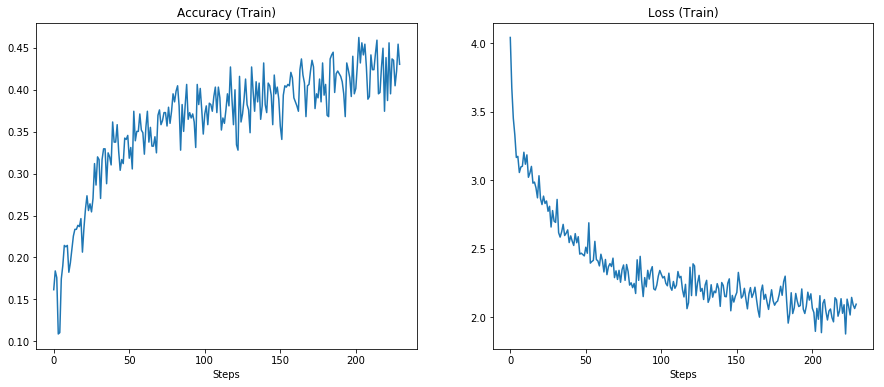

In [5]:
seq_length = 25
learning_rate = 0.01
epoch = 1
batch_size = 25
alice_dataset = Dataset([alice_txt], seq_length)
alice_model = RNNTextGenerator(
    seq_length,
    alice_dataset.vocab_size,
    rnn_cell=tf.nn.rnn_cell.BasicRNNCell,
    learning_rate=learning_rate,
    epoch=epoch,
    batch_size=batch_size,
)

alice_model_scores = alice_model.fit(
    alice_dataset,
    save_scores=True
)
fig, axes = plt.subplots(figsize=(15, 6), ncols=2)
alice_model_scores['accuracy'].plot(
    ax=axes[0], title='Accuracy (Train)'
)
alice_model_scores['loss'].plot(
    ax=axes[1], title='Loss (Train)'
)
for ax in axes:
    ax.set(xlabel='Steps')

For part I of this project, we create a basic RNN text generator using the same parameters as karpathy. We can see the accuracy and loss have not converged. Each `fit` call will run one epoch (we passed `epoch=1` to the constructor). 

We want to continue fitting the model with more epochs for 30 more seconds, and we're interested in how the model improves over time.

In [6]:
def time_limit(
        days=0,
        seconds=0,
        microseconds=0,
        milliseconds=0,
        minutes=0,
        hours=0,
        weeks=0
):
    start_time = datetime.now()
    delta = timedelta(
        days=days,
        seconds=seconds,
        milliseconds=milliseconds,
        minutes=minutes,
        hours=hours,
        weeks=weeks
    )
    while delta > datetime.now() - start_time:
        yield

In [7]:
for _ in time_limit(seconds=30):
    alice_model.fit(alice_dataset)
    acc, loss = alice_model.score(alice_dataset)
    print('test acc: {}, test loss: {}'.format(
        acc, loss
    ))
    start_seq = 'Yes, but '
    print(start_seq + alice_model.generate(
        alice_dataset,
        start_seq,
        100
    ))
    print('-----------------------')

test acc: 0.535040020942688, test loss: 1.592130422592163
Yes, but much towe this NOT, aft open') said 'Letger comimpie hone,
'U VERY up in aborious, it with the adge,
-----------------------
test acc: 0.5360000133514404, test loss: 1.5756181478500366
Yes, but the Habembood cacs must, was the lang donant as perpen my his huril about harriered me shreep), whre
-----------------------
test acc: 0.5430399775505066, test loss: 1.5500394105911255
Yes, but to Alice.

So then
hep datee went orling,' said Alice,' said had geined,' she you not!' said the
nil
-----------------------
test acc: 0.5302400588989258, test loss: 1.6037070751190186
Yes, but the could mould cobl over howner? Now that oplo-thing to her orverewn.'

'Why, to
herself!

The Qu-e
-----------------------
test acc: 0.539199948310852, test loss: 1.6024020910263062
Yes, but the Queen home way the at the placsarnd of the sat a it,' the QUED INK Affece herge how eacushing ov
-----------------------
test acc: 0.5388799905776978, tes

We can see the generated text does become better over time. There are more actual words in the sentence. The test accuracy and loss are still improving.

This concludes part I of this project. For part II, we will try different hyperparameters and use a different text dataset.

## ModelSelector
Defined in
[src/model_selector.py](https://github.com/donaldong/rnn-text-gen/blob/master/src/model_selector.py)

Performs randomized search and rank the models by accuracy. It selects the best
ranking models and allows lengthy searching (for hours/days).

### Methods

#### constructor
```
ModelSelector(
  dataset,
  params,
  n_samples=5,
):
```
##### Args
- `dataset`
A `Dataset` object to train the model.
- `params`
A dictionary which describes the search space.  The each key of the dictionary
stores a list of parameters. The selector randomly choice a parameter value
from the list, for each parameter key.
- `n_samples`
The number of times to sample from the dataset for testing. The selector uses
the average accuracy to rank the models.

#### search
```
search()
```
Search the parameter space. It generates a combination of parameters, fit, and
score the text generator. The selector keeps track of the model and its average
accuracy and score on the test data.

##### Returns
A fitted `RNNTextGenerator`.

##### Example
```python
params = {
    'learning_rate': np.linspace(0, 1, 10000, endpoint=False),
    'epoch': np.arange(1, 6),
    'batch_size': np.arange(25, 100),
}
selector = ModelSelector(dataset, params)
for _ in range(n):
  selector.search()
```
It will randomly select a `learning_rate`, `epoch`, and `batch_size` for the
`RNNTextGenerator`, and fit it `n` times.

#### as_df
```
as_df()
```
Save the searching result (models and their scores) as a pandas data frame.
```
                                               model  accuracy        loss
0  {'vocab_size': 70, 'rnn_cell': <class 'tensorf...  0.094519   88.173103
1  {'vocab_size': 70, 'rnn_cell': <class 'tensorf...  0.068282  104.829025
2  {'vocab_size': 70, 'rnn_cell': <class 'tensorf...  0.052424   12.201582
```

##### Returns
A `pd.DataFrame` sorted by `accuracy` in non-increasing order.

#### best_models
```
best_models(n)
```
Get the top `n` models ordered by their accuracies.

##### Args
- `n`
The numer of best models.

##### Returns
A list of `RNNTextGenerator` with length `n`.

#### best_model
```
best_model()
```
Get the model with the highest accuracy. It wraps the `best_models` method.

##### Returns
An `RNNTextGenerator` with the highest accuracy among the models the selector
has seen so far.

In [8]:
class ModelSelector:
    def __init__(
            self,
            dataset,
            params,
            n_samples=5,
    ):
        self._dataset = dataset
        self._params = params
        self._models = []
        self._acc = []
        self._loss = []
        self._n_samples = n_samples

    def search(self):
        selected = {}
        for name, options in self._params.items():
            selected[name] = np.random.choice(options)
        model = RNNTextGenerator(
            self._dataset.seq_length,
            self._dataset.vocab_size,
            **selected
        )
        model.fit(self._dataset)
        acc, loss = model.score(
            self._dataset,
            n_samples=self._n_samples
        )
        self._models.append(model)
        self._acc.append(acc)
        self._loss.append(loss)
        return model

    def as_df(self):
        return pd.DataFrame({
            'model': self._models,
            'accuracy': self._acc,
            'loss': self._loss,
        }).sort_values(
            by=['accuracy'],
            ascending=False,
        )

    def best_models(self, n):
        return self.as_df().head(n)['model'].values[0]

    def best_model(self):
        return self.best_models(1)

In [9]:
params = {
    'rnn_cell': [
        tf.nn.rnn_cell.BasicRNNCell,
        tf.nn.rnn_cell.LSTMCell,
        tf.nn.rnn_cell.GRUCell,
    ],
    'n_neurons': np.arange(1, 500),
    'activation': [
        tf.nn.leaky_relu,
        tf.nn.elu,
        tf.tanh,
    ],
    'optimizer': [
        tf.train.AdamOptimizer,
        tf.train.GradientDescentOptimizer,
    ],
    'learning_rate': np.linspace(0, 1, 10000, endpoint=False),
    'epoch': np.arange(1, 200),
    'batch_size': np.arange(25, 100),
}

alice_models = ModelSelector(alice_dataset, params)

In [10]:
for _ in time_limit(hours=24):
    alice_models.search()
    # Save as a file to peek the results
    alice_models.as_df().head(10).to_csv('alice_models.csv')

We define a large search space for the model selector and give it 24 hours to search. We hope it would discover an excellent model for the `Alice in Wonderland` text.

In [11]:
alice_models.as_df().head(5)

,model,accuracy,loss
57,"{'vocab_size': 70, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>, 'n_neurons': 320, 'activation': <function leaky_relu at 0x7f5ca98fc400>, 'optimizer': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'learning_rate': 0.006, 'epoch': 45, 'batch_size': 91, 'name': 'RNNTextGenerator'}",0.624527,1.252932
30,"{'vocab_size': 70, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>, 'n_neurons': 310, 'activation': <function leaky_relu at 0x7f5ca98fc400>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.757, 'epoch': 181, 'batch_size': 60, 'name': 'RNNTextGenerator'}",0.611333,1.533815
91,"{'vocab_size': 70, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>, 'n_neurons': 121, 'activation': <function leaky_relu at 0x7f5ca98fc400>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.78, 'epoch': 111, 'batch_size': 33, 'name': 'RNNTextGenerator'}",0.606303,1.304429
134,"{'vocab_size': 70, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>, 'n_neurons': 289, 'activation': <function leaky_relu at 0x7f5ca98fc400>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.666, 'epoch': 183, 'batch_size': 133, 'name': 'RNNTextGenerator'}",0.605714,1.373469
45,"{'vocab_size': 70, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>, 'n_neurons': 227, 'activation': <function elu at 0x7f5caa1c19d8>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.75, 'epoch': 112, 'batch_size': 39, 'name': 'RNNTextGenerator'}",0.597949,1.524433


In [12]:
# The best model
best_model = selector.best_model()

The best model the selector has seen uses a `GRU Cell` with `320` neurons and `leaky_relu` as the activation function. It uses an `AdamOptimizer` with a learning rate of `0.006`. It's trained in `45` epochs, with `91` sequences per batch (batch_size). It has an average accuracy of `0.6245` and loss of `1.25` over 5 randomly sampled test sequences.

In [13]:
start_seq = 'Yes, but'
print(start_seq + best_model.generate(
    alice_dataset,
    start_seq,
    150
))

Yes, but to talk about this of ketched him in the puppy juging said to the tell messave off, things very unfusts, and that put on hesserriely I'll
make the pu


We consider `epoch` as a hyperparameter of the model since a big number of epochs can allow the neural net to overfit and perform poorly on the test sequences. Thus, the best model from the selector is the final model we will use.


The best text generator is deployed as [a simple web application](https://www.ddong.me/alice-text-gen) (`https://www.ddong.me/alice-text-gen`) for educational purposes.

# Generating Lyrics for Christmas Songs 

In [14]:
seq_length = 12
song_dataset = Dataset([songs_txt], seq_length)

In [15]:
song_models = ModelSelector(song_dataset, params)

In [16]:
for _ in time_limit(minutes=10):
    song_models.search()

In [17]:
song_models.as_df()

,model,accuracy,loss
4,"{'vocab_size': 77, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>, 'n_neurons': 295, 'activation': <function tanh at 0x7f3552dfdc80>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.9475, 'epoch': 132, 'batch_size': 34, 'name': 'RNNTextGenerator'}",0.556373,2.174386
5,"{'vocab_size': 77, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>, 'n_neurons': 117, 'activation': <function elu at 0x7f3552ef29d8>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.8124, 'epoch': 180, 'batch_size': 96, 'name': 'RNNTextGenerator'}",0.524826,1.982630
0,"{'vocab_size': 77, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>, 'n_neurons': 145, 'activation': <function leaky_relu at 0x7f355262d400>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.7249, 'epoch': 35, 'batch_size': 49, 'name': 'RNNTextGenerator'}",0.493197,1.800170
6,"{'vocab_size': 77, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>, 'n_neurons': 23, 'activation': <function elu at 0x7f3552ef29d8>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.9009, 'epoch': 105, 'batch_size': 30, 'name': 'RNNTextGenerator'}",0.472778,1.876379
1,"{'vocab_size': 77, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>, 'n_neurons': 269, 'activation': <function tanh at 0x7f3552dfdc80>, 'optimizer': <class 'tensorflow.python.training.gradient_descent.GradientDescentOptimizer'>, 'learning_rate': 0.8292, 'epoch': 23, 'batch_size': 63, 'name': 'RNNTextGenerator'}",0.461111,1.959167
3,"{'vocab_size': 77, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.BasicRNNCell'>, 'n_neurons': 195, 'activation': <function elu at 0x7f3552ef29d8>, 'optimizer': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'learning_rate': 0.0427, 'epoch': 18, 'batch_size': 26, 'name': 'RNNTextGenerator'}",0.368590,2.458522
2,"{'vocab_size': 77, 'rnn_cell': <class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>, 'n_neurons': 119, 'activation': <function tanh at 0x7f3552dfdc80>, 'optimizer': <class 'tensorflow.python.training.adam.AdamOptimizer'>, 'learning_rate': 0.7853, 'epoch': 127, 'batch_size': 71, 'name': 'RNNTextGenerator'}",0.260563,3.091667


In [18]:
# The best model
song_model = song_models.best_model()

In [19]:
start_seq = 'Merry'
print(start_seq + song_model.generate(
    song_dataset,
    start_seq,
    50
))

Merry, Merry Christmas, dancing, 
Shephey nour cleing o


Since the `song` dataset does not have as much data as the `alice` dataset, we reduce the `seq_length` to make the model more meaningful. 

We follow the exact procedure as before. After getting the best model, we start sampling with "Merry," and we're likely to get a sentence which contains "Merry Christmas." We send our best wishes to people who are reading this report in the holiday season. Merry Christmas!

# Conclusion
This project provides a great learning experience of exploring tensorflow API. Here are some highlights and encountered challenges we want to share:

### Version control
The Jupyter Notebook is a great tool to share solutions and reports with others. However, Jupyter Notebook does not have the strongest compatibility with Git. The `execution_count` often results in conflicts. When keep adding features, the length of the notebook can easily become too long to do things manage efficiently, for example when the order of cell execution is changed, the behavior of the code can also change. This can make debugging more costly.

To avoid conflicts, we clear the cell outputs before staging the changes. Our biggest recommendation is to have modulized classes and import them into the Jupyter Notebook to help avoid code duplication. We used the notebook as the final stage of the development to describe interfaces at the highest level.

### Project management
This is a decent sized school project. While sizewise, it would be ideal to split the work among the team members for the best learning experience, many parts of the project have to be finished sequentially. For example, one could not tune a model without the model constructed or the data prepared.

Our solution is to have modulized classes and build minimum test cases. We design our API together and construct parts of it assuming the other parts are working correctly. For example, the `Dataset` class and the `RNNTextGenerator` class were built independently. We had code to create batches filled with random data.

We use Git and Github as the main tools to manage the project. We created 30+ issues, 2 sub-projects, and 30+ pull requests. It helped us to record our ideas and make concrete progress.

### Input tensors with a different shape
The most challenging part in building the text generator is to handle the fact that we're sampling from the model using a different sequence length. Our solution is to construct a different graph and restore the weights of the variables. The same logic can also be applied to serving the model in a web application.

### Sneaky bugs
The bugs related to the weights are tricky to resolve. Here is a simple bug which took us 30 minutes to resolve: In the development process, we forgot to restore the weights to the new graph. When we recover the graph definition, the weights problem occurs again. The model could have very unexpected behavior if the weights are not correctly recovered with the source of the unexpected behavior not being easy to find.

### Sklearn API
We were considering to use the sklearn API, however, it does not work very well in our use cases. For example, we could not take advantage of running training the models on different treads, and we don't need to apply cross-validation during the randomized search. Adapting our modules for the sklearn API seems to be an overkill for this project.

### Eager Execution
We were using the Eager Execution feature. However, it turns out to be not necessary for our use case, and it stops many other components from working properly. For example, the `tf.summary.FileWriter`. We believe this feature is still in its early stage. For this reason, we stopped using eager execution.

### Data Recovery

As with any computational task, the possibility of an unexpected fault increases with time. For a model stored in memory, an unexpected power fluctuation could instantly erase hours of training. While no crash is known to have occurred, the model was designed in such a way to avoid losing progress in the event that it did happen. By having each model stored in a file that uses the model's name, the long-term training algorithm is given the ability to pick up where training left off. In the event that a crash or loss of power was to occur, the training algorithm would be able to start with weights from the previous training session.

### Restore the graph
When serving the trained model, we need to restore the graph completely. Tensorflow has different APIs for doing similar things (such the saver and builder). We do not consider restoring the graph as an easy task.

### Training the model over time

Most models can afford to be trained until they are ready to use, or until an optimal model is found. In our case, however, multiple models needed to be trained without us being able to manually stop training to move to the next model. To resolve this, we created a time based for loop, which would stop initiating training once a certain amount of time has passed. With this tool, the next model was able to initiate training without manual intervention.